# 1 Modelo: XGBoost

✅ Carga Inicial de datos para Modelo XGBoost

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import joblib
import matplotlib.pyplot as plt

# 1. Cargar datos
df = pd.read_csv('sell_in_features_final.csv')
df['periodo'] = pd.to_datetime(df['periodo'])

# Cargar lista de productos objetivo
df_target_products = pd.read_csv('product_id_apredecir201912.txt', sep='\t')
target_product_ids = df_target_products['product_id'].unique()  # Asumiendo que la columna se llama 'product_id'

# 2. Filtrar solo los productos que necesitamos predecir
df = df[df['product_id'].isin(target_product_ids)]

#df["log_tn+2"] = np.log1p(df["tn+2"])

# 2. División temporal
train_df = df[df['periodo'] <= '2019-10-01'].copy()
test_df = df[df['periodo'] == '2019-12-01'].copy()

# 3. Separar features y target
features_to_drop = ['tn+2', 'periodo', 'product_id', 'tn']
X_train = train_df.drop(columns=features_to_drop)
y_train = train_df['tn+2']
X_test = test_df.drop(columns=features_to_drop)
y_test = test_df['tn+2']

# 4. Manejo de valores faltantes en features y target

# a) Primero eliminar filas donde el target es NaN
print(f"Registros iniciales en train: {len(X_train)}")
valid_idx = y_train.notna()
X_train = X_train[valid_idx]
y_train = y_train[valid_idx]
print(f"Registros después de eliminar target NaN: {len(X_train)}")

# b) Imputación de features
print("\nValores NaN en features antes de imputación:")
print(X_train.isna().sum().sort_values(ascending=False).head(10))

# Imputador para features (versión robusta)
imputer = IterativeImputer(random_state=42, max_iter=20, skip_complete=True)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convertir a DataFrame
X_train_clean = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_clean = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# 5. Escalado de características
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

Registros iniciales en train: 20789
Registros después de eliminar target NaN: 20789

Valores NaN en features antes de imputación:
autocorr_6      1042
tn_std_12        780
tn_std_3         780
tn_std_6         780
autocorr_3       675
autocorr_1       639
entropy_6         63
tn_min_12          0
tn_max_12          0
tn_median_12       0
dtype: int64


✅ Entrenar Modelo 


Evaluación XGBoost:
- MAE: 8.4534
- RMSE: 26.1280
- R2: 0.9270


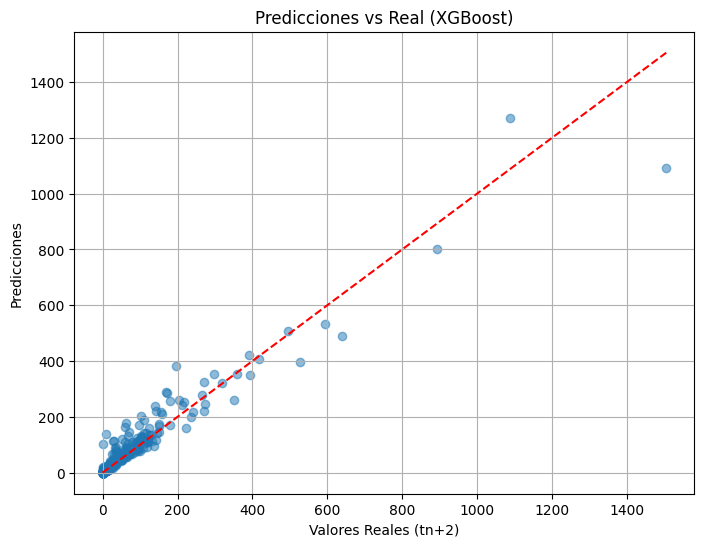

In [2]:
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Modelo: XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)


#  Evaluación de Modelos
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nEvaluación {model_name}:")
    print(f"- MAE: {mae:.4f}")
    print(f"- RMSE: {rmse:.4f}")
    print(f"- R2: {r2:.4f}")
    
    # Gráfico de dispersión
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.title(f'Predicciones vs Real ({model_name})')
    plt.xlabel('Valores Reales (tn+2)')
    plt.ylabel('Predicciones')
    plt.grid()
    plt.show()
    

# Evaluación
evaluate_model(y_test, xgb_pred, "XGBoost")

✅ CSV Para Kaggle

In [5]:
# 1. Crear DataFrame con todas las predicciones
predictions_df = pd.DataFrame({
    'product_id': test_df['product_id'].values,
    'xgb_pred': xgb_pred,
    'real_value': y_test.values
})

# 2. Eliminar duplicados (por si hay múltiples registros por producto)
predictions_df = predictions_df.drop_duplicates(subset=['product_id'], keep='first')

# 3. Verificar que tenemos 780 productos
if len(predictions_df) != 780:
    # Si faltan productos, completar con la media
    all_products = pd.read_csv('product_id_apredecir201912.txt', sep='\t')
    predictions_df = pd.merge(all_products, predictions_df, on='product_id', how='left')
    
    # Imputar valores faltantes con la media del modelo respectivo
    for col in ['xgb_pred']:
        predictions_df[col] = predictions_df[col].fillna(predictions_df[col].mean())

# 4. Formatear y redondear valores
for col in ['xgb_pred']:
    predictions_df[col] = predictions_df[col].round(5)

# 5. Exportar archivos individuales para cada modelo
# XGBoost
predictions_df[['product_id', 'xgb_pred']].rename(columns={'xgb_pred': 'tn'}) \
    .to_csv('submission_xgboost.csv', index=False, float_format='%.5f')

print("\nArchivos de submission creados:")
print("- submission_xgboost.csv")



Archivos de submission creados:
- submission_xgboost.csv


# 2 - Modelo: Regresión Lineal

✅ Carga Inicial de datos para Modelo RL

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Ruta de los archivos (ajustar según tu entorno)
sellin = pd.read_csv('sell-in.txt', sep='\s+')
productos = pd.read_csv('tb_productos.txt', sep='\t')
stocks = pd.read_csv('tb_stocks.txt', sep='\s+')

df_target_products = pd.read_csv('product_id_apredecir201912.txt', sep='\t')

# Verificamos carga
print("Sell-in:", sellin.shape)
print("Productos:", productos.shape)
print("stocks:", stocks.shape)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\01994\AppData\Local\Temp\ipykernel_17852\3527524689.py:6: SyntaxWarning: invalid escape sequence '\s'
  sellin = pd.read_csv('sell-in.txt', sep='\s+')
C:\Users\01994\AppData\Local\Temp\ipykernel_17852\3527524689.py:8: SyntaxWarning: invalid escape sequence '\s'
  stocks = pd.read_csv('tb_stocks.txt', sep='\s+')


Sell-in: (2945818, 7)
Productos: (1262, 6)
stocks: (13691, 3)


✅ Agrupar y crear dataset a nivel product_id × periodo

In [7]:
# Agrupar tn por producto y periodo
df = sellin.groupby(["product_id", "periodo"])["tn"].sum().reset_index()
df = df.sort_values(["product_id", "periodo"])

# Generar los lags tn_1 a tn_11 y clase = tn en periodo+2
for i in range(1, 12):
    df[f"tn_{i}"] = df.groupby("product_id")["tn"].shift(i)

# tn_0 es el tn actual
df.rename(columns={"tn": "tn_0"}, inplace=True)

# Clase: tn del mes +2
df["clase"] = df.groupby("product_id")["tn_0"].shift(-2)

✅ Seleccionar los 33 productos magicos

In [8]:
# Lista correcta de productos mágicos
magicos = [20002, 20003, 20006, 20010, 20011, 20018, 20019, 20021,
           20026, 20028, 20035, 20039, 20042, 20044, 20045, 20046,
           20049, 20051, 20052, 20053, 20055, 20008, 20017, 20086,
           20180, 20193, 20320, 20532, 20612, 20637, 20807, 20838]

# 1. Dataset de entrenamiento (solo productos mágicos y periodo=201812)
df_train = df[(df["periodo"] == 201812) & (df["product_id"].isin(magicos))].copy()

# 2. Filtrar los registros completos
df_train = df_train.dropna(subset=["clase"] + [f"tn_{i}" for i in range(12)])

✅ Entrenar Modleo

In [9]:
X_train = df_train[[f"tn_{i}" for i in range(12)]]
y_train = df_train["clase"]
modelo_lr = LinearRegression().fit(X_train, y_train)


✅ Para los productos incompletos usar el promedio y aplicar la regresion

In [10]:
# 1. Dataset base: periodo 201912 → para predecir 202002
df_pred = df[df["periodo"] == 201912].copy()
df_pred["periodo"] = 202002
df_pred["anio"] = 2020
df_pred["mes"] = 2
df_pred["clase"] = np.nan  # target desconocido

# 2. Lista de columnas tn_0 a tn_11
vars_tn = [f"tn_{i}" for i in range(12)]

# 3. Rellenar NaNs con el promedio propio de los tn disponibles
df_pred[vars_tn] = df_pred[vars_tn].T.apply(lambda x: x.fillna(x.mean()), axis=0).T

# 4. Aplicar regresión lineal a todos los registros
X_pred = df_pred[vars_tn]
df_pred["tn_p2_predicha"] = modelo_lr.predict(X_pred)

✅ Salida CSV

In [11]:
# 1. Cargar los product_id válidos para Kaggle
ids_validos = df_target_products["product_id"]

# 2. Filtrar predicciones para quedarte solo con los 780 productos válidos
submission = df_pred[df_pred["product_id"].isin(ids_validos)][["product_id", "tn_p2_predicha"]].copy()

# 3. Renombrar columna como requiere Kaggle
submission.rename(columns={"tn_p2_predicha": "tn"}, inplace=True)

# 4. Validar cantidad de productos
assert len(submission) == 780, f"❌ Submission tiene {len(submission)} productos, no 780."

# 5. Exportar a CSV
submission.to_csv("submission_kaggle_regresion.csv", index=False, float_format="%.5f")
print("✅ Archivo 'submission_kaggle_regresion.csv' generado correctamente con 780 productos.")


✅ Archivo 'submission_kaggle_regresion.csv' generado correctamente con 780 productos.


# 3 - Ensamble

In [12]:

# 1️⃣ Cargar predicciones individuales
df_xgb = pd.read_csv('submission_xgboost.csv')
df_lr = pd.read_csv('submission_kaggle_regresion.csv')

# 2️⃣ Validar que ambas tienen los 780 productos esperados
assert len(df_xgb) == 780 and len(df_lr) == 780, "⚠️ Los archivos no tienen 780 productos."

# 3️⃣ Unir predicciones por product_id
df_ensamble = pd.merge(df_xgb, df_lr, on='product_id', suffixes=('_xgb', '_lr'))

# 4️⃣ Calcular ensamble como promedio
df_ensamble['tn'] = df_ensamble[['tn_xgb', 'tn_lr']].mean(axis=1).round(5)

# 5️⃣ Exportar CSV final
df_ensamble[['product_id', 'tn']].to_csv('CSV_xgb_lr_from.csv', index=False)

print("\n✅ Ensamble generado directamente desde CSVs.")
print("- submission_stacked_xgb_lr_from.csv")


✅ Ensamble generado directamente desde CSVs.
- submission_stacked_xgb_lr_from.csv
